## Feedbacks visualization
Simple bar graph based on code from IH (the true OG).

In [114]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, re
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, average_and_wrap, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

### Check running location and adjust working directory appropriately.

In [115]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(fb_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [116]:
os.listdir(fb_dir)

['CAM61_1_1_check2',
 'CAM61_satcomp_SFC_wbf_1_inp_1',
 'CAM61_satcomp_wbf_1_inp_1',
 'CAM61_1_1_GFDL_kernels',
 'CAM6_satcomp_FLTKERN_wbf_1_inp_1',
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
 'CAM61_test_GFDL_FLT',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
 'CAM61_satcomp_SFC_wbf_0.2_inp_0.1',
 'CAM61_satcomp_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFC_wbf_0.5_inp_0.05',
 'CAM6_satcomp_SFCKERN_wbf_1_inp_1',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_wbf_0.5_inp_0.5',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM6_Fvars_check',
 'TOA_GFDL_KERNEL',
 'CAM6_satcomp_wbf_1.25_inp_10',
 'CAM6_satcomp_SFC_wbf_1.25_inp_10',
 'CAM6_satcomp_wbf_1_inp_1']

In [25]:
case_fbs = org_feedbacks_case('CAM6_satcomp_SFCnew_wbf_1.25_inp_10')

In [ ]:
case_fbs['fb_albedo_ttsky'][0,:,:].plot(robust=True)

In [26]:
comp_feedbacks(case_fbs)

fb_albedo_ttsky :  0.738900315037216
fb_cloud_sw :  -1.011832201021358
fb_cloud_lw :  0.32144539891133006
fb_adj_cloud_sw :  -0.6273809349612769
fb_adj_cloud_lw :  0.5274760770004107
fb_water_vapor_sw_ttsky :  -0.1782634659558658
fb_water_vapor_lw_ttsky :  0.8309739472604658
fb_lapse_rate_ttsky :  0.08891802409099563
fb_planck_ttsky :  -0.30299216566822296
cell_weight :  0.004766985970241943


## Helper Functions

In [117]:
def org_feedbacks_case(case_path):
    '''
    This function take a directory path that 
    contains feedback files (via Lise script).
    It opens each feedback file and extracts the needed feedback variables,
    which are stored in a single dataset object (returned).
    '''
    _fbs = os.listdir("%s/%s" % (fb_dir,case_path)) # List feedback files
    
    # Calculate the averaged Arctic quantities for each file appropriately:
    # Albedo feedback
    _albedo_file = [i for i in _fbs if "albedo_feedback" in i][0]
    _albedo = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_albedo_file)).sel(run=0))
    _albedo_vars = ['fb_albedo_ttsky']
    
    # Create a new dataset object to store specific variables within
    _all_fb = _albedo[_albedo_vars[0]].to_dataset(name=_albedo_vars[0])
    _albedo.close()
    
    # Cloud feedbacks
    _cld_file = [i for i in _fbs if "cloud_feedback" in i][0] # select file, a little clunky to avoid using regular expressions
    _cld = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_cld_file)).sel(run=0))    
    cld_vars = ["fb_cloud_sw","fb_cloud_lw","fb_adj_cloud_sw","fb_adj_cloud_lw"]
    for _var in cld_vars:
        _all_fb[_var] = _cld[_var]
    _cld.close()
    
    # Water Vapor feedback (separate files)
    _wv_sw_file = [i for i in _fbs if "water_vapor_sw" in i][0]    
    _wv_lw_file = [i for i in _fbs if "water_vapor_lw" in i][0]
    _wv_sw = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_wv_sw_file)).sel(run=0))
    _wv_lw = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_wv_lw_file)).sel(run=0))
    _wv_vars = ["fb_water_vapor_sw_ttsky", "fb_water_vapor_lw_ttsky"] # Will need to zip
    for _var,_da in zip(_wv_vars,[_wv_sw,_wv_lw]):
        _all_fb[_var] = _da[_var]
        _da.close()
        
    # Lapse Rate feedback
    _lr_file = [i for i in _fbs if "lapse_rate" in i][0]
    _lr = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_lr_file)).sel(run=0))
    _lr_vars =["fb_lapse_rate_ttsky"]
    for _var in _lr_vars:
        _all_fb[_var] = _lr[_var]
    _lr.close()
    
    # Planck feedback
    _planck_file = [i for i in _fbs if "planck_feedback" in i][0]
    _planck = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_planck_file)).sel(run=0))
    _planck_vars = ['fb_planck_ttsky']
    for _var in _planck_vars:
        _all_fb[_var] = _planck[_var]
    _planck.close()

    _all_fb = add_weights(_all_fb)
    
    return _all_fb

In [118]:
def comp_feedbacks(fb_ds):
    '''
    This function averages feedbacks in the Arctic Circle,
    weighting by the gridcell area and month duration.
    '''
    # Used for weighting by month. I tested this and it didn't make a big change here, but could elsewhere.
    wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
    month_length = xr.DataArray(wgt_mon, coords=[fb_ds['fb_albedo_ttsky']['month']], name='month_length')

    # This matrix cross-product will allow me to do all of my weighting in a single step.
    all_weights = month_length @ fb_ds['cell_weight']
    
    for _var in fb_ds.data_vars:
        _ds = fb_ds[_var]
        mask = _ds['lat'] < 66
        _arc_val = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
        print(_var, ": ", _arc_val.values)

In [119]:
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' %height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=11,
                    ha='center', va='bottom')

In [120]:
def autolabel3(rects,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height < 0: # for consistent placement
            txtxy = (0,-14)
        else:
            txtxy = (0,3)
        ax.annotate('%.2f' %height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=txtxy,  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=11,
                    ha='center', va='bottom')

In [121]:
def weight_feedbacks(case_dict,weights=None,labels=None):
    '''
    Takes a dictionary of organized feedbacks/cases.
    Computes an annual average for each feedback and
    stores in individual lists in a returned dictionary object.
    Currently adding functionality to handle unnormalized feedbacks.
    Weights will be a dictionary with identical keys to case_dict.
    '''
    
    # Used for weighting by month. I tested this and it didn't make a big change here, but could elsewhere.
    wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
    
    # Pick a random variable to use coords from here
    sample = next(iter( case_dict.values() ))
#     sample = case_dict[case_dict.keys()[0]]['fb_albedo_ttsky']['month']
    month_length = xr.DataArray(wgt_mon, coords=[sample['fb_albedo_ttsky']['month']], name='month_length')

    # This matrix cross-product will allow me to do all of my weighting in a single step.
    all_weights = month_length @ sample['cell_weight']
    
    barvals_PL = []
    barvals_LR = []
    barvals_WV = []
    barvals_A = []
    barvals_CLSW = []
    barvals_CLLW = []
    
    cases = []
    if labels:
        keys = labels.keys()
    else: 
        keys = case_dict.keys()
    for _mod in keys:
        print(_mod)
#         print(weights[_mod])
        _da = case_dict[_mod]

        _avg_dict = {}
        cases.append(_mod)
        for _var in _da.data_vars:
            _ds = _da[_var]
            mask = _ds['lat'] < 66
            _arc_val = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
    #             print(_var, ": ", _arc_val.values)
            if weights: # Normalize by Arctic increase
                _avg_dict[_var] = _arc_val.values / weights[_mod]
            else:
                _avg_dict[_var] = _arc_val.values 

        barvals_PL.append(_avg_dict['fb_planck_ttsky'])        
        barvals_LR.append(_avg_dict['fb_lapse_rate_ttsky'])
        barvals_WV.append(_avg_dict['fb_water_vapor_sw_ttsky']+_avg_dict['fb_water_vapor_lw_ttsky'])
        barvals_A.append(_avg_dict['fb_albedo_ttsky'])
        barvals_CLSW.append(_avg_dict['fb_adj_cloud_sw'])
        barvals_CLLW.append(_avg_dict['fb_adj_cloud_lw'])
            
    outdict = dict(planck_fb = barvals_PL,
                   lapserate_fb = barvals_LR,
                   watervapor_fb = barvals_WV,
                   albedo_fb = barvals_A,
                   cloudsw_fb = barvals_CLSW,
                   cloudlw_fb = barvals_CLLW
                  )
    
    return outdict

In [204]:
def barplot_feedbacks(case_dict,weighted_fbs,labels=None):
    '''
    Plot the weighted annual feedbacks using a bar plot.
    '''
    
    fig, ax = plt.subplots(figsize=(15.,6))

    if labels:
        keys = labels.values()
    else:
        keys = case_dict.keys()
    xind = range(len(keys))
    width = 0.167         # the width of the bars
#     xind_p1 = [i-(width*2.5) for i in xind]
#     xind_p2 = [i-(width*1.5) for i in xind]
#     xind_p3 = [i-(width*0.5) for i in xind]
#     xind_p4 = [i+(width*0.5) for i in xind]
#     xind_p5 = [i+(width*1.5) for i in xind]
#     xind_p6 = [i+(width*2.5) for i in xind]
#     p1 = ax.bar(xind_p1, weighted_fbs['planck_fb'], width, label='Planck')
#     p2 = ax.bar(xind_p2, weighted_fbs['lapserate_fb'], width, label='Lapse Rate')
#     p3 = ax.bar(xind_p3, weighted_fbs['watervapor_fb'], width, label='Water Vapor')
#     p4 = ax.bar(xind_p4, weighted_fbs['albedo_fb'], width, label='Albedo')
#     p5 = ax.bar(xind_p5, weighted_fbs['cloudsw_fb'], width, label='adj. SW-cloud')
#     p6 = ax.bar(xind_p6, weighted_fbs['cloudlw_fb'], width, label='adj. LW-cloud')

#     autolabel3(p1,ax)
#     autolabel3(p2,ax)
#     autolabel3(p3,ax)
#     autolabel3(p4,ax)
#     autolabel3(p5,ax)
#     autolabel3(p6,ax)

    width = 0.25         # the width of the bars
    xind_p1 = [i-(width*1.5) for i in xind]
    xind_p2 = [i-(width*0.5) for i in xind]
    xind_p3 = [i+(width*0.5) for i in xind]
    xind_p4 = [i+(width*1.5) for i in xind]
    
    fbs = [weighted_fbs['planck_fb'], weighted_fbs['lapserate_fb'],
           weighted_fbs['watervapor_fb'], weighted_fbs['albedo_fb'],
           weighted_fbs['cloudsw_fb'], weighted_fbs['cloudlw_fb']]
    
    p1 = ax.bar(xind_p1, weighted_fbs['cloudsw_fb'], width, label='adj. SW-cloud')
    p2 = ax.bar(xind_p2, weighted_fbs['cloudlw_fb'], width, label='adj. LW-cloud')
    p3 = ax.bar(xind_p3, weighted_fbs['lapserate_fb'], width, label='Lapse Rate')
    net_fb = np.sum(fbs, axis=0)
    p4 = ax.bar(xind_p4, net_fb, width, label='Net Feedback')

    autolabel3(p1,ax)
    autolabel3(p2,ax)
    autolabel3(p3,ax)
    autolabel3(p4,ax)
#     plt.ylim(min(barvals_PL)-0.05,abs(min(barvals_PL))+0.05)

    ax.set_xticks(xind)
    if labels:
        ax.set_xticklabels(keys, fontsize=12,rotation=30)
    else:
        ax.set_xticklabels(keys, rotation=45)#, fontsize=15)

#     ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('Planck', 'Lapse Rate', 'Water Vapor', 'Albedo', 'adj. SW-cloud', 'adj. LW-cloud'))
    ax.legend((p1[0], p2[0], p3[0], p4[0]), ('adj. SW-cloud', 'adj. LW-cloud','Lapse Rate','Net'))

    ax.set_ylabel('[Wm$^{-2}$K$^{-1}$]',fontsize=18)
    
    return fig,ax

In [230]:
def barplot_feedbacks1(case_dict,weighted_fbs,labels=None):
    '''
    Plot the weighted annual feedbacks using a bar plot.
    '''
    
    fig, ax = plt.subplots(figsize=(15.,6))

    if labels:
        keys = labels.values()
    else:
        keys = case_dict.keys()
    xind = range(len(keys))
    width = 0.167         # the width of the bars
    xind_p1 = [i-(width*2.5) for i in xind]
    xind_p2 = [i-(width*1.5) for i in xind]
    xind_p3 = [i-(width*0.5) for i in xind]
    xind_p4 = [i+(width*0.5) for i in xind]
    xind_p5 = [i+(width*1.5) for i in xind]
    xind_p6 = [i+(width*2.5) for i in xind]
    p1 = ax.bar(xind_p1, weighted_fbs['planck_fb'], width, label='Planck')
    p2 = ax.bar(xind_p2, weighted_fbs['lapserate_fb'], width, label='Lapse Rate')
    p3 = ax.bar(xind_p3, weighted_fbs['watervapor_fb'], width, label='Water Vapor')
    p4 = ax.bar(xind_p4, weighted_fbs['albedo_fb'], width, label='Albedo')
    p5 = ax.bar(xind_p5, weighted_fbs['cloudsw_fb'], width, label='adj. SW-cloud')
    p6 = ax.bar(xind_p6, weighted_fbs['cloudlw_fb'], width, label='adj. LW-cloud')

    autolabel3(p1,ax)
    autolabel3(p2,ax)
    autolabel3(p3,ax)
    autolabel3(p4,ax)
    autolabel3(p5,ax)
    autolabel3(p6,ax)

    ax.set_xticks(xind)
    if labels:
        ax.set_xticklabels(keys, fontsize=12,rotation=30)
    else:
        ax.set_xticklabels(keys, rotation=45)#, fontsize=15)

    ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('Planck', 'Lapse Rate', 'Water Vapor', 'Albedo', 'adj. SW-cloud', 'adj. LW-cloud'))
    ax.set_ylabel('[Wm$^{-2}$K$^{-1}$]',fontsize=18)
    
    return fig,ax

In [123]:
def calc_arc_dT(initial_ts,final_ts):
    '''
    This function takes the path to inital and final 
    surface temperature files. It averages over months and
    calculates the average annual warming in the Arctic (>66N), 
    weighting by cell area and month length.
    '''
    
    # Open TS timeseriesinput files
    ts_i = xr.open_dataset(initial_ts)
    ts_f = xr.open_dataset(final_ts)

    # Take the difference and average across months.
    _d_ts = (ts_f['TS'] - ts_i['TS']).groupby('time.month').mean('time')
    d_ts = add_weights(_d_ts.to_dataset())

    # Create month length object for weighting
    wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31] # month length (days)
    month_length = xr.DataArray(wgt_mon, coords=[d_ts['month']], name='month_length')

    # Combine weights via matrix product
    all_weights = month_length @ d_ts['cell_weight']

    mask = d_ts['lat'] < 66 # Mask below the Arctic
    _arc_val = masked_average(d_ts['TS'],dim=['lat','lon','month'],weights=all_weights,mask=mask)
    
    return _arc_val
    

In [187]:
def plot_months_line(dict_cases, var, lat_range=[66,82], dTS=None,
                     bias=False, ax=None, labels=None, **kwargs):
    colors = sns.color_palette("colorblind")
    months = ['J','F','M','A','M','J','J','A','S','O','N','D'] # month initials
    
    if ax:
        axes = ax
        plt.sca(ax)
        fig=None
    else:
        fig, axes = plt.subplots(nrows=1,ncols=1,figsize=[15,10])
        
    lines = []
    for k,color in zip(dict_cases,colors):
        _run = dict_cases[k]
        mon_vals = _run[var].sel(lat=slice(lat_range[0],lat_range[1]))

        mon_vals2 = add_weights(mon_vals)
        _weights = mon_vals['cell_weight']
            
        out_dat = masked_average(mon_vals2, dim=['lat','lon'], weights=_weights)
        if dTS:
            out_dat = out_dat / dTS[k]
        if labels:
            _lbl = labels[k]
        else:
            _lbl = k

        _ln = out_dat.plot(ax=axes,label=_lbl, color=color, **kwargs)

    plt.xticks(np.arange(0,len(months)+1,1), months) # this works I guess
    plt.legend(labels.keys()) # JKS
    
    axes.set_xlabel('Month',fontsize=16)
    axes.set_title('')    
    axes.set_ylabel("%s (%s)" % (dict_cases[k][var].long_name,'Wm$^{-2}$K$^{-1}$'), fontsize=16)
    axes.hlines(0,0,12, linestyle='dashed',color='gray')
    axes.set_xbound(0,11)    

    return fig, axes

In [229]:
def barplot_single(case_dict,weighted_fbs,var,labels=None,vals=None):
    '''
    Plot the weighted annual feedbacks across the different models 
    for a single variable.
    '''
    colors = sns.color_palette('colorblind')    
    
    fig, ax = plt.subplots(figsize=(8.,6))

    if label_dict:
        keys = label_dict.values()
    else:
        keys = case_dict.keys()
    
    if vals:
        sorted_vals = []
        for i in case_dict.keys():
            sorted_vals.append(vals[i])
        p1 = ax.bar(keys, sorted_vals, label='adj. SW-cloud',color=colors)
    else:
        p1 = ax.bar(keys, weighted_fbs[var], label='adj. SW-cloud',color=colors)

    autolabel3(p1,ax)

    if labels:
        ax.set_xticklabels(keys, fontsize=12,rotation=30)
    else:
        ax.set_xticklabels(keys, rotation=45)#, fontsize=15)

#     ax.legend((p1[0], p2[0], p3[0], p4[0]), ('adj. SW-cloud', 'adj. LW-cloud','Lapse Rate','Net'))
    ax.set_ylabel('[Wm$^{-2}$K$^{-1}$]',fontsize=18)
    
    return fig,ax

## Calculate average feedback values for the Arctic
Make sure to weight correctly by both area and month length.

### Arctic-normalized Feedbacks

### Calculate the Arctic-average temperature increase.

In [11]:
os.listdir('feedbacks_soden/mod_by_me/output_jonahks/')

['CAM61_1_1_check2',
 'CAM61_satcomp_SFC_wbf_1_inp_1',
 'CAM61_satcomp_wbf_1_inp_1',
 'CAM61_1_1_GFDL_kernels',
 'CAM6_satcomp_FLTKERN_wbf_1_inp_1',
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
 'CAM61_test_GFDL_FLT',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
 'CAM61_satcomp_SFC_wbf_0.2_inp_0.1',
 'CAM61_satcomp_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFC_wbf_0.5_inp_0.05',
 'CAM6_satcomp_SFCKERN_wbf_1_inp_1',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_wbf_0.5_inp_0.5',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM6_Fvars_check',
 'TOA_GFDL_KERNEL',
 'CAM6_satcomp_wbf_1.25_inp_10',
 'CAM6_satcomp_SFC_wbf_1.25_inp_10',
 'CAM6_satcomp_wbf_1_inp_1']

In [124]:
prefix = 'feedbacks_soden/mod_by_me/timeseriesinput'

path_dict = {}

path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM61_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = '%s/CAM61_satcomp_wbf_0.2_inp_0.1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = '%s/CAM61_satcomp_wbf_0.5_inp_0.5/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM6_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = '%s/CAM6_satcomp_wbf_1.25_inp_10/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CESM2_satcomp_wbf_1_inp_1/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = '%s/CESM2_satcomp_wbf_1_inp_100/' % prefix

ts_dict = {}
for i in path_dict:
    _t = path_dict[i]
    _files = os.listdir(_t)
    for ii in _files: # this won't handle errors well...
        if "4K" in ii:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_f = "%s/%s" % (_path,ts_file[0])
#             print("4K: ", ts_f)
        else:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_i = "%s/%s" % (_path,ts_file[0])
#             print("Norm: ",ts_i)
            
    ts_dict[i] = calc_arc_dT(ts_i,ts_f)
    
print(ts_dict)

{'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.89348545), 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
array(5.06160638), 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
array(4.97446844), 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.86478516), 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
array(4.8824035), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(5.11944737), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
array(5.29178813)}


In [125]:
cases2 = os.listdir(fb_dir)
case_dict2 = {} # Cases are keys, feedback dictionaries are values


for _case in cases2:
    if "SFCnonorm" in _case:
        print(_case)
        case_dict2[_case] = org_feedbacks_case(_case)

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CESM2_satcomp_SFCnonorm_wbf_1_inp_100
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1


In [126]:
# Testing something to order cases and label them.
label_dict = {}
label_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-Oslo"
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6"
label_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-OsloIce"
label_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = 'CAM6-Oslo Fit 1'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = 'CAM6-OsloIce Fit 2'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = 'CAM6-OsloIce Fit 3'
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = "CAM6 Fit 4"

In [127]:
desired_order_list = ['CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
                      'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
                      'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_100'
                      ]

case_dict2b = {k: case_dict2[k] for k in desired_order_list}

In [128]:
out2 = weight_feedbacks(case_dict2b,weights=ts_dict,labels=label_dict)

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f748f8400>)

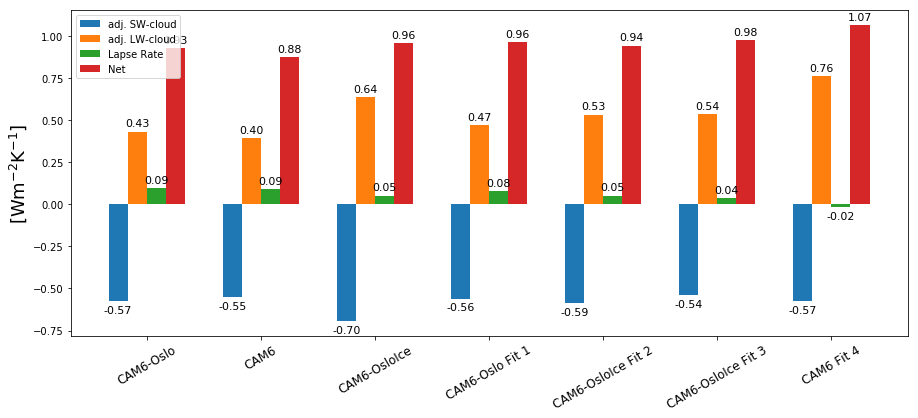

In [203]:
barplot_feedbacks(case_dict2b,out2,labels=label_dict)

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4ee0226978>)

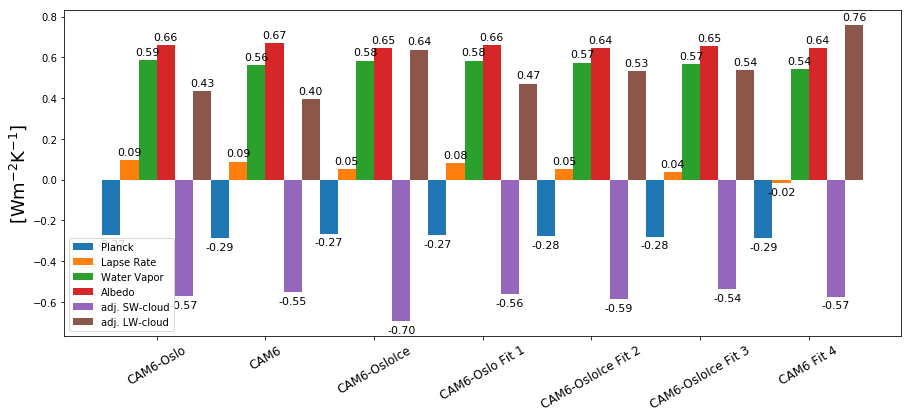

In [231]:
barplot_feedbacks1(case_dict2b,out2,labels=label_dict)

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f748ab748>)

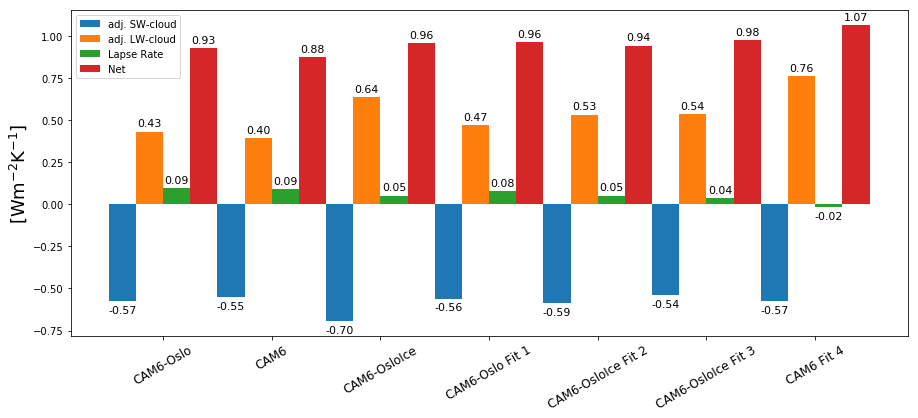

In [205]:
barplot_feedbacks(case_dict2b,out2,labels=label_dict)

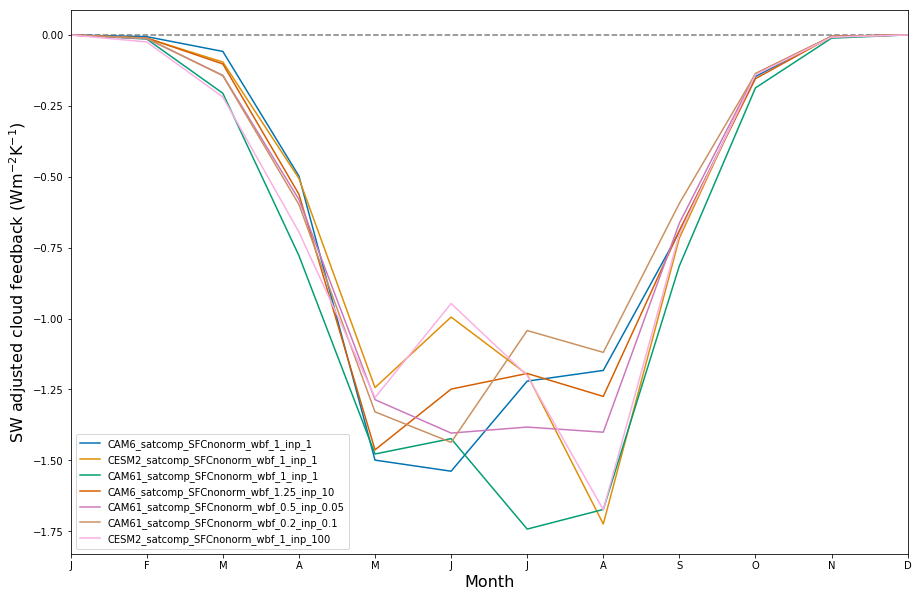

In [183]:
fig_out,axes_out = plot_months_line(case_dict2b,'fb_adj_cloud_sw',labels=label_dict,lat_range=[66,90],dTS=ts_dict)

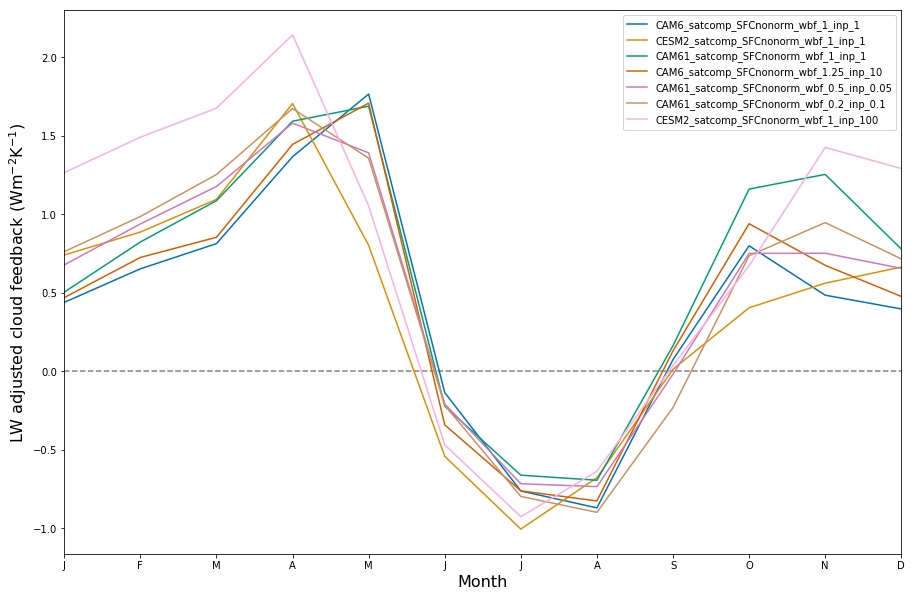

In [184]:
fig_out,axes_out = plot_months_line(case_dict2b,'fb_adj_cloud_lw',labels=label_dict,lat_range=[66,90],dTS=ts_dict)

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4eda0bad68>)

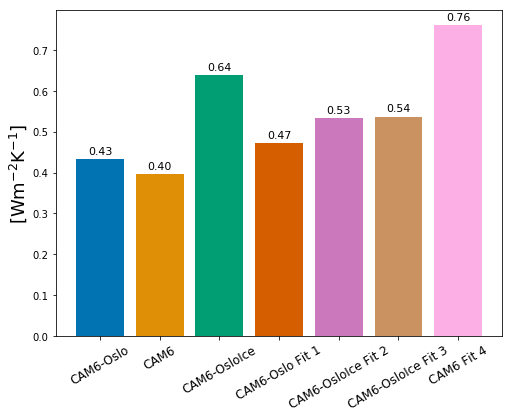

In [222]:
barplot_single(case_dict2b,out2,'cloudlw_fb',labels=label_dict)

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4eda008898>)

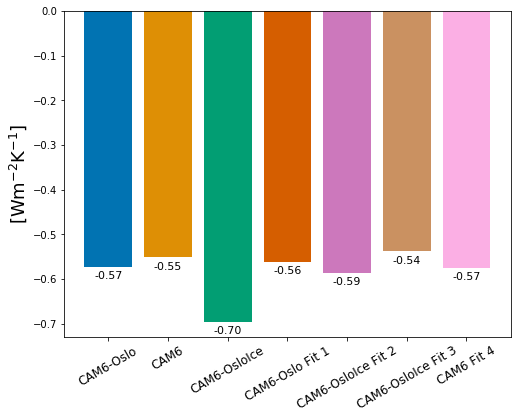

In [223]:
barplot_single(case_dict2b,out2,'cloudsw_fb',labels=label_dict)

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4eda079e48>)

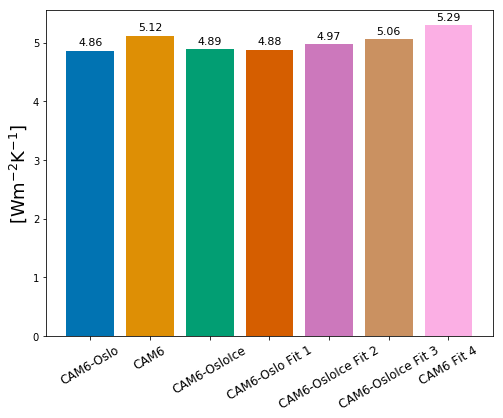

In [228]:
barplot_single(case_dict2b,out2,'cloudsw_fb',labels=label_dict,vals=ts_dict)

### Normalized Feedbacks

In [43]:
cases = os.listdir(fb_dir)
case_dict = {} # Cases are keys, feedback dictionaries are values


for _case in cases:
    if (not "SFCno" in _case and "SFC" in _case): # Filter SFC kernels    
        print(_case)
        case_dict[_case] = org_feedbacks_case(_case)

CAM61_satcomp_SFC_wbf_1_inp_1
CAM61_satcomp_SFC_wbf_0.2_inp_0.1
CAM61_satcomp_SFC_wbf_0.5_inp_0.05
CAM6_satcomp_SFCKERN_wbf_1_inp_1
CAM6_satcomp_SFC_wbf_1.25_inp_10


In [44]:
out = weight_feedbacks(case_dict)

CAM61_satcomp_SFC_wbf_1_inp_1
CAM61_satcomp_SFC_wbf_0.2_inp_0.1
CAM61_satcomp_SFC_wbf_0.5_inp_0.05
CAM6_satcomp_SFCKERN_wbf_1_inp_1
CAM6_satcomp_SFC_wbf_1.25_inp_10


(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f70542ac8>)

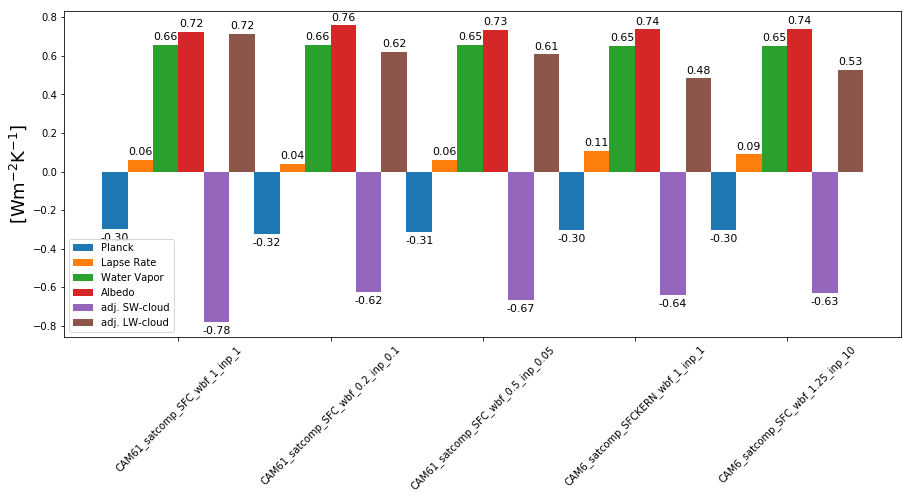

In [45]:
barplot_feedbacks(case_dict,out)

## Old Stuff

## JShaw notes
__Albedo variables:__  
<u> fb_albedo_clrsky:</u> Clear-sky albedo feedback by grid.  
<u> fb_albedo_clrsky_glAvg:</u> Global average clear-sky albedo feedback by month.  
<u>fb_albedo_ttsky:</u> Total-sky albedo feedback by grid.  
<u>fb_albedo_ttsky_glAvg:</u> Global average total-sky albedo feedback by month.  

__Lapse Rate variables:__ (these are structured the same as albedo)  
    <u>fb_lapse_rate_clrsky</u>  
    <u>fb_lapse_rate_clrsky_glAvg</u>  
    <u>fb_lapse_rate_ttsky</u>  
    <u>fb_lapse_rate_ttsky_glAvg</u>  
__Planck feedbacks:__ also structured the same  
Long- and Short-wave water vapor feedbacks too, as well as temperature feedback 

__Cloud Feedbacks:__  
    <u>fb_cloud_sw:</u> SW cloud feedback  
    <u>fb_cloud_sw_glAvg</u> Monthly Global average SW cloud feedback  
    <u>fb_cloud_lw</u> LW cloud feedback  
    <u>fb_cloud_lw_glAvg</u> Monthly Global average LW cloud feedback  
    <u>fb_adj_cloud_sw</u> "Adjusted" SW cloud feedback  
    <u>fb_adj_cloud_sw_glAvg</u> Monthly Global average "Adjusted" SW cloud feedback  
    <u>fb_adj_cloud_lw</u> "Adjusted" LW cloud feedback  
    <u>fb_adj_cloud_lw_glAvg</u> Monthly Global average "Adjusted" LW cloud feedback  

# IH stuff for reference

In [ ]:
#++ Info:
#----------------------------------------------------
#
#       Inger Helene Hafsahl Karset
#       February 13th 2020
#
#----------------------------------------------------
#-- End info

#++ Import modules
#----------------------------------------------------
from netCDF4 import Dataset
import numpy as np
import glob
import os
from matplotlib.pylab import *
import matplotlib.colors as colors
from matplotlib.ticker import ScalarFormatter
import seaborn as sns; 
sns.set(color_codes=True,font_scale=1.5)
sns.set_style("darkgrid")
#--------------------------------------------------
#-- End import modules

In [ ]:
#++ Input, top be modified:
#--------------------------------------------------
models = ['NorESM2-LM', 'EC-Earth3-Veg', 'NorESM2-MM', 'UKESM1-0-LL']

#--------------------------------------------------
#-- End of input to be modified. Do no modify code below

# NB: values need to be updated! 
ECS_all = {'NorESM2-LM': 2.53, 'NorESM2-MM': 2.51, 'EC-Earth3-Veg': 4.37, 'UKESM1-0-LL': 5.39}
SLOPE_all = {'NorESM2-LM': -1.35, 'NorESM2-MM': -1.47, 'EC-Earth3-Veg': -0.78, 'UKESM1-0-LL': -0.66}
SUM_all = {'NorESM2-LM': -1.94, 'NorESM2-MM': -1.85, 'EC-Earth3-Veg': -1.29, 'UKESM1-0-LL': -1.0}  #++IH: NB! default is 0. modify later!!
SUM_all_adj = {'NorESM2-LM': -1.57, 'NorESM2-MM': -1.45, 'EC-Earth3-Veg': -0.83, 'UKESM1-0-LL': -0.71}  #++IH: NB! default is 0. modify later!!
PL_all = {'NorESM2-LM': -3.50, 'NorESM2-MM': -3.51, 'EC-Earth3-Veg': -3.47, 'UKESM1-0-LL': -3.41}
LR_all = {'NorESM2-LM': -0.62, 'NorESM2-MM': -0.64, 'EC-Earth3-Veg': -0.39, 'UKESM1-0-LL': -0.38}
WV_all = {'NorESM2-LM': 2.02, 'NorESM2-MM': 2.09, 'EC-Earth3-Veg': 2.01, 'UKESM1-0-LL': 1.66}
A_all = {'NorESM2-LM': 0.49, 'NorESM2-MM': 0.47, 'EC-Earth3-Veg': 0.74, 'UKESM1-0-LL': 0.62}
CLSW_all = {'NorESM2-LM': 0.17, 'NorESM2-MM': 0.26, 'EC-Earth3-Veg': 0.02, 'UKESM1-0-LL': 1.06}
CLSW_all_adj = {'NorESM2-LM': 0.28, 'NorESM2-MM': 0.37, 'EC-Earth3-Veg': 0.22, 'UKESM1-0-LL': 1.19}
CLLW_all = {'NorESM2-LM': -0.50, 'NorESM2-MM': -0.52, 'EC-Earth3-Veg': -0.20, 'UKESM1-0-LL': -0.55}
CLLW_all_adj = {'NorESM2-LM': -0.24, 'NorESM2-MM': -0.23, 'EC-Earth3-Veg': 0.06, 'UKESM1-0-LL': -0.39}

In [ ]:
# Plot barplots showing ECS and TCR together
ECS_all_sorted = {f:ECS_all[f] for f in sorted(ECS_all, key=ECS_all.__getitem__)} 
#figure(num = 1, figsize = (6.,3.))
fig, ax = plt.subplots(figsize=(15.,4))
xind_tmp = range(len(ECS_all_sorted))
xind = [i*1.05 for i in xind_tmp]
#barvals1 = list(ECS_all_sorted.values()) 
barvals_PL = []
barvals_LR = []
barvals_WV = []
barvals_A = []
barvals_CLSW = []
barvals_CLLW = []
for modelname in list(ECS_all_sorted.keys()):
    #print('modelname = ', modelname)
    #print('TCR = ', TCR_all[modelname])
    barvals_PL.append(PL_all[modelname])
    barvals_LR.append(LR_all[modelname])
    barvals_WV.append(WV_all[modelname])
    barvals_A.append(A_all[modelname])
    barvals_CLSW.append(CLSW_all_adj[modelname])
    barvals_CLLW.append(CLLW_all_adj[modelname])

width = 0.167         # the width of the bars
xind_p1 = [i-(width*2.5) for i in xind]
xind_p2 = [i-(width*1.5) for i in xind]
xind_p3 = [i-(width*0.5) for i in xind]
xind_p4 = [i+(width*0.5) for i in xind]
xind_p5 = [i+(width*1.5) for i in xind]
xind_p6 = [i+(width*2.5) for i in xind]
p1 = ax.bar(xind_p1, barvals_PL, width, label='Planck')
p2 = ax.bar(xind_p2, barvals_LR, width, label='Lapse Rate')
p3 = ax.bar(xind_p3, barvals_WV, width, label='Water Vapor')
p4 = ax.bar(xind_p4, barvals_A, width, label='Albedo')
p5 = ax.bar(xind_p5, barvals_CLSW, width, label='adj. SW-cloud')
p6 = ax.bar(xind_p6, barvals_CLLW, width, label='adj. LW-cloud')
#print(xind)
#print(width)
#xind_width = [i+width for i in xind]
#xind_width05 = [i+(width*0.5) for i in xind]
#ax.set_xticks(xind_width05)
ax.set_xticks(xind)
ax.set_xticklabels(list(ECS_all_sorted.keys()), rotation=45)
ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('Planck', 'Lapse Rate', 'Water Vapor', 'Albedo', 'adj. SW-cloud', 'adj. LW-cloud'))

In [ ]:
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' %height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=11,
                    ha='center', va='bottom')
autolabel2(p1)
autolabel2(p2)
autolabel2(p3)
autolabel2(p4)
autolabel2(p5)
autolabel2(p6)
plt.ylim(min(barvals_PL)-0.2,abs(min(barvals_PL))+0.2)
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1.0), fontsize=16)
title('CMIP6; Feedbacks (years 141-150)')
ylabel('[Wm$^{-2}$K$^{-1}$]')
savefig('Feedbacks_all', bbox_inches='tight')
close(1)